In [1]:
import numpy as np
import math
import cmath
import scipy.special
import matplotlib.pyplot as plt
import cv2
import sympy
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from scipy.stats import ttest_ind

In [63]:
r=1/math.sqrt(2)
m=r**2
L=1/2*scipy.special.ellipk(m)*cmath.exp(math.pi/4*1j)

#conformal mapping from the unit square to the unit disk

def f(z):

    y=math.sqrt(2)*L*z
    phi = y.real
    psi = y.imag
    v0=scipy.special.ellipj(phi,m)
    v1=scipy.special.ellipj(psi,1-m)
    delta = v1[1]**2 + m*v0[0]**2*v1[0]**2 
    sni = (v0[0]*v1[2] + 1j*v0[1]*v0[2]*v1[0]*v1[1])/delta
    dni = (v0[2]*v1[1]*v1[2] - 1j*m*v0[0]*v0[1]*v1[0])/delta
    w=1/math.sqrt(2)/cmath.exp(math.pi/4*1j)*sni/dni

    return(w)

#conformal mapping from the unit disk to the unit square

def invf(z):

    omega=math.sqrt(2)*cmath.exp(math.pi/4*1j)*z/(1+1j*z**2)**(1/2)
    y=np.arcsin(omega)
    phi=y.real
    psi=y.imag
    #to avoid singularity of COT(phi) at zero add EPS
    eps=0.00001
    if abs(phi)<eps:
        phi=eps
    #finding the roots of the equation X^2 - (cot(phi)^2+m*sinh(psi)^2*csc(phi)^2-1+m)X - (1-m)*cot(phi)^2 = 0
    b = -(sympy.cot(phi)**2 + m*np.sinh(psi)**2*sympy.csc(phi)**2-1+m)
    c = -(1-m)*sympy.cot(phi)**2;
    X1 = -b/2+math.sqrt(b**2/4-c)
    if X1>=0:
        lam = sympy.acot(math.sqrt(X1))    
    if X1<0:
        X2 = -b/2-math.sqrt(b**2/4-c)
        lam = sympy.acot(math.sqrt(X2))
    if 1/m*(np.tan(phi)**2*sympy.cot(lam)**2-1)<0:
        mu=0
    else:
        mu = sympy.atan(math.sqrt(1/m*(np.tan(phi)**2*sympy.cot(lam)**2-1)))
    #change of variables taking into account periodicity ceil to the right
    lam = (-1)**np.floor(phi/math.pi*2)*lam + math.pi*np.ceil(phi/math.pi-0.5+eps)
    mu = np.sign(psi)*mu
    F1 = scipy.special.ellipkinc(float(lam),m)
    F2 = scipy.special.ellipkinc(float(mu),1-m)
    Fi = F1 + F2*1j
    w=1/(math.sqrt(2)*L)*Fi
    
    return(w)

z=-0.3+0.3j
w=f(z)
z1=invf(w)

print(abs(z-z1))

7.850462293418876e-17


In [14]:
def squareToDisk(img):

  #the image is assumed to be a square!
  img_height=img.shape[0]

  #imgH is a vector telling the location of the points corresponding with the pixels of the image in the interval [-1,1]
  imgH=np.array(range(img_height))/(img_height-1)*2-1
 
  #u is the relative distance between two adjacent pixels
  u=imgH[1]-imgH[0]

  #we need the values of those points mapped from the unit square onto the unit disk that determine the pixels producing the final image
  #to obtain these values, we first need to find out the original locations of these pixel points before the mapping
  #this is done with the inverse mapping that maps the unit disk onto the unit square
  #after that, we compute the values of the pixel points with weighted means of the four vertices

  img1=np.zeros((img.shape))
  for i in range(img_height):
    for j in range(img_height):
      if imgH[i]**2+imgH[j]**2<1:
        z=complex(imgH[i],imgH[j])
        w=invf(z)
        i0=int(np.floor((w.real+1)/u))
        i1=(w.real+1)/u-i0
        j0=int(np.floor((w.imag+1)/u))
        j1=(w.imag+1)/u-j0
        if len(img.shape)==2:
          img1[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
        else:
          for k in range(img.shape[2]):
            img1[i,j,k]=i1*j1*img[i0,j0,k]+(1-i1)*j1*img[i0+1,j0,k]+i1*(1-j1)*img[i0,j0+1,k]+(1-i1)*(1-j1)*img[i0+1,j0+1,k]

  return img1

In [15]:
def diskToSquare(img):

  img_height=img.shape[0]
  imgH=np.array(range(img_height))/(img_height-1)*2-1
  u=imgH[1]-imgH[0]

  img1=np.zeros((img.shape))
  for i in range(img_height):
    for j in range(img_height):
      z=complex(imgH[i],imgH[j])
      w=f(z)
      i0=int(np.floor((w.real+1)/u))
      i1=(w.real+1)/u-i0
      j0=int(np.floor((w.imag+1)/u))
      j1=(w.imag+1)/u-j0
      if len(img.shape)==2:
        img1[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
      else:
        for k in range(img.shape[2]):
          img1[i,j,k]=i1*j1*img[i0,j0,k]+(1-i1)*j1*img[i0+1,j0,k]+i1*(1-j1)*img[i0,j0+1,k]+(1-i1)*(1-j1)*img[i0+1,j0+1,k]

  return img1

In [16]:
def mobius(img,alp):

  img_height=img.shape[0]
  imgH=np.array(range(img_height))/(img_height-1)*2-1
  u=imgH[1]-imgH[0]

  img1=np.zeros((img.shape))
  for i in range(img_height):
    for j in range(img_height):
      if imgH[i]**2+imgH[j]**2<1:
        z=complex(imgH[i],imgH[j])
        w=(z+alp)/(1+np.conj(alp)*z)
        i0=int(np.floor((w.real+1)/u))
        i1=(w.real+1)/u-i0
        j0=int(np.floor((w.imag+1)/u))
        j1=(w.imag+1)/u-j0
        if len(img.shape)==2:
          img1[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
        else:
          for k in range(img.shape[2]):
            img1[i,j,k]=i1*j1*img[i0,j0,k]+(1-i1)*j1*img[i0+1,j0,k]+i1*(1-j1)*img[i0,j0+1,k]+(1-i1)*(1-j1)*img[i0+1,j0+1,k]

  return img1

In [17]:
def rotation(img,kul):

  img_height=img.shape[0]
  imgH=np.array(range(img_height))/(img_height-1)*2-1
  u=imgH[1]-imgH[0]

  img1=np.zeros((img.shape))
  for i in range(img_height):
    for j in range(img_height):
      if imgH[i]**2+imgH[j]**2<1:
        z=complex(imgH[i],imgH[j])
        w=z*cmath.exp(kul*1j)
        i0=int(np.floor((w.real+1)/u))
        i1=(w.real+1)/u-i0
        j0=int(np.floor((w.imag+1)/u))
        j1=(w.imag+1)/u-j0
        if len(img.shape)==2:
          img1[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
        else:
          for k in range(img.shape[2]):
            img1[i,j,k]=i1*j1*img[i0,j0,k]+(1-i1)*j1*img[i0+1,j0,k]+i1*(1-j1)*img[i0,j0+1,k]+(1-i1)*(1-j1)*img[i0+1,j0+1,k]

  return img1

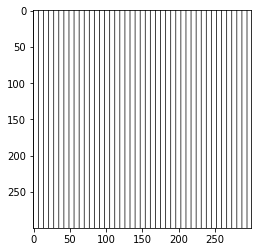

KeyboardInterrupt: 

In [18]:
img_height=300
img=np.zeros((img_height,img_height))
for i in range(img_height):
  for j in range(img_height):
    if j%7>=1:
      img[i,j]=1
plt.imshow(img,cmap='gray')
plt.show()
img1=squareToDisk(img)
plt.imshow(img1,cmap='gray')
plt.show()
alp=0.3+0.3j
img2=mobius(img1,alp)
plt.imshow(img2,cmap='gray')
plt.show()
kul=math.pi/3
img3=rotation(img2,kul)
plt.imshow(img3,cmap='gray')
plt.show()
img4=diskToSquare(img3)
plt.imshow(img4,cmap='gray')
plt.show()

In [19]:
def lineImgs(img):

  img_height=img.shape[0]

  imgH=np.array(range(img_height))/(img_height-1)*2-1
 
  u=imgH[1]-imgH[0]

  img1=np.zeros((img.shape))
  img2=np.zeros((img.shape))
  img3=np.zeros((img.shape))

  for i in range(img_height):
    for j in range(img_height):
      z=complex(imgH[i],imgH[j])
      x=f(z)
      kul=math.pi/3
      y=x*cmath.exp(kul*1j)
      alp=0.3+0.3j
      v=(y+alp)/(1+np.conj(alp)*y)
      w=invf(v)
      i0=min(int(np.floor((w.real+1)/u)),img_height-2)
      i1=(w.real+1)/u-i0
      j0=min(int(np.floor((w.imag+1)/u)),img_height-2)
      j1=(w.imag+1)/u-j0
      img1[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
      if abs(z)<1:
        y=z*cmath.exp(kul*1j)
        v=(y+alp)/(1+np.conj(alp)*y)
        w=invf(v)
        i0=min(int(np.floor((w.real+1)/u)),img_height-2)
        i1=(w.real+1)/u-i0
        j0=min(int(np.floor((w.imag+1)/u)),img_height-2)
        j1=(w.imag+1)/u-j0
        img2[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
        v=(z+alp)/(1+np.conj(alp)*z)
        w=invf(v)
        i0=min(int(np.floor((w.real+1)/u)),img_height-2)
        i1=(w.real+1)/u-i0
        j0=min(int(np.floor((w.imag+1)/u)),img_height-2)
        j1=(w.imag+1)/u-j0
        img3[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]

  return [img1,img2,img3]   

In [20]:
img_height=300
img=np.zeros((img_height,img_height))
for i in range(img_height):
  for j in range(img_height):
    if j%7>=1:
      img[i,j]=1
img0=squareToDisk(img)
img3,img2,img1=lineImgs(img)

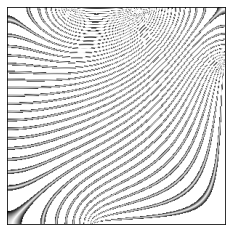

In [40]:
plt.imshow(img3,cmap='gray')
fig=plt.gcf()
plt.xticks([],labels='')
plt.yticks([],labels='')
plt.tick_params(left = False,top=False)
plt.show()
fig.savefig('l_img_3.png',bbox_inches='tight')

In [46]:
def drawDisk(img,c,r):

  img_height=img.shape[0]
  imgH=np.array(range(img_height))/(img_height-1)*2-1

  for i in range(img_height):
    for j in range(img_height):
      z=complex(imgH[i],imgH[j])
      if abs(z-c)<r:
        img[i,j]=0

  return img   

In [21]:
def augImg3(img):

  img_height=img.shape[0]

  imgH=np.array(range(img_height))/(img_height-1)*2-1
 
  u=imgH[1]-imgH[0]

  img1=np.zeros((img.shape))
  img2=np.zeros((img.shape))
  img3=np.zeros((img.shape))

  for i in range(img_height):
    for j in range(img_height):
      z=complex(imgH[i],imgH[j])
      x=f(z)
      kul=math.pi/3
      y=x*cmath.exp(kul*1j)
      alp=0.1+0.1j
      v=(y+alp)/(1+np.conj(alp)*y)
      w=invf(v)
      i0=min(int(np.floor((w.real+1)/u)),img_height-2)
      i1=(w.real+1)/u-i0
      j0=min(int(np.floor((w.imag+1)/u)),img_height-2)
      j1=(w.imag+1)/u-j0
      img1[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
      kul=math.pi
      y=x*cmath.exp(kul*1j)
      alp=0.1+0.3j
      v=(y+alp)/(1+np.conj(alp)*y)
      w=invf(v)
      i0=min(int(np.floor((w.real+1)/u)),img_height-2)
      i1=(w.real+1)/u-i0
      j0=min(int(np.floor((w.imag+1)/u)),img_height-2)
      j1=(w.imag+1)/u-j0
      img2[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]
      kul=1.5*math.pi
      y=x*cmath.exp(kul*1j)
      alp=0.3+0.3j
      v=(y+alp)/(1+np.conj(alp)*y)
      w=invf(v)
      i0=min(int(np.floor((w.real+1)/u)),img_height-2)
      i1=(w.real+1)/u-i0
      j0=min(int(np.floor((w.imag+1)/u)),img_height-2)
      j1=(w.imag+1)/u-j0
      img3[i,j]=i1*j1*img[i0,j0]+(1-i1)*j1*img[i0+1,j0]+i1*(1-j1)*img[i0,j0+1]+(1-i1)*(1-j1)*img[i0+1,j0+1]

  return [img1,img2,img3]   

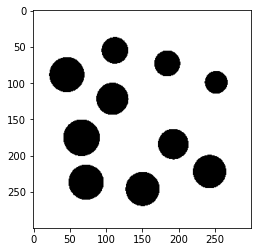

In [160]:
img_height=300
img=np.ones((img_height,img_height))
numOfDisks=10
c1=[np.random.uniform(low=-0.7,high=0.7)+np.random.uniform(low=-0.7,high=0.7)*1j]
for i in range(numOfDisks-1):
    c=np.random.uniform(low=-0.7,high=0.7)+np.random.uniform(low=-0.7,high=0.7)*1j
    while(min(abs(np.array(c1)-c))<0.4):
        c=np.random.uniform(low=-0.7,high=0.7)+np.random.uniform(low=-0.7,high=0.7)*1j
    c1.append(c)
r1=np.random.uniform(low=0.1,high=0.17,size=numOfDisks)
for i in range(numOfDisks):
    img=drawDisk(img,c1[i],r1[i])
plt.imshow(img,cmap='gray')
plt.show()

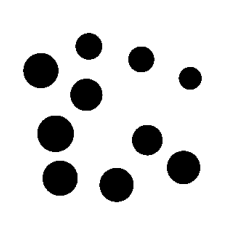

In [161]:
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img_4_{}.png'.format(numOfDisks),bbox_inches='tight')

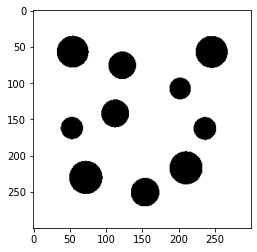

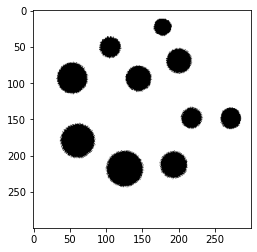

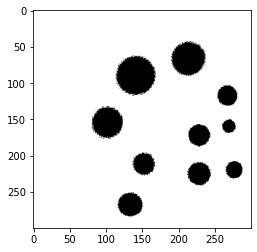

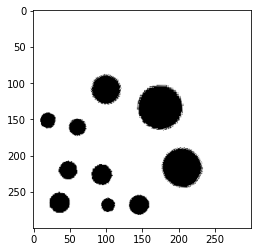

In [80]:
img1,img2,img3=augImg3(img)
plt.imshow(img,cmap='gray')
plt.show()
plt.imshow(img1,cmap='gray')
plt.show()
plt.imshow(img2,cmap='gray')
plt.show()
plt.imshow(img3,cmap='gray')
plt.show()

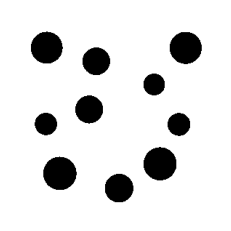

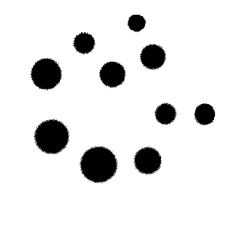

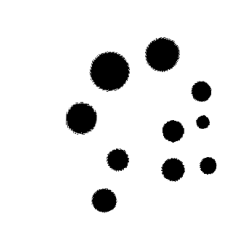

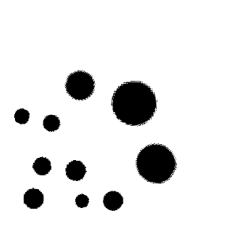

In [81]:
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img0_{}.png'.format(numOfDisks),bbox_inches='tight')
plt.imshow(img1,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img1_{}.png'.format(numOfDisks),bbox_inches='tight')
plt.imshow(img2,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img2_{}.png'.format(numOfDisks),bbox_inches='tight')
plt.imshow(img3,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img3_{}.png'.format(numOfDisks),bbox_inches='tight')

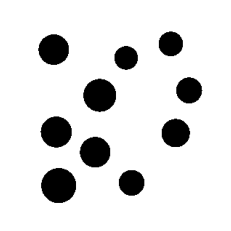

In [275]:
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img_35_0_{}.png'.format(numOfDisks),bbox_inches='tight')

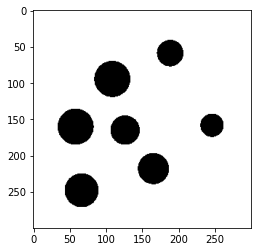

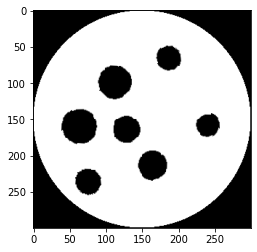

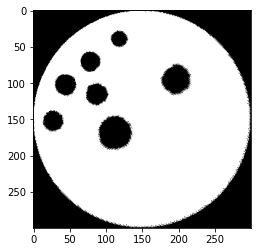

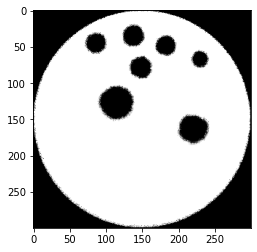

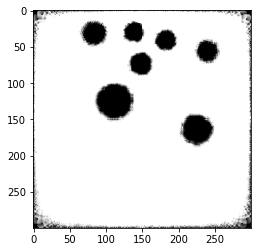

In [105]:
plt.imshow(img,cmap='gray')
plt.show()
img1=squareToDisk(img)
plt.imshow(img1,cmap='gray')
plt.show()
alp=0.3+0.3j
img2=mobius(img1,alp)
plt.imshow(img2,cmap='gray')
plt.show()
kul=math.pi/3
img3=rotation(img2,kul)
plt.imshow(img3,cmap='gray')
plt.show()
img4=diskToSquare(img3)
plt.imshow(img4,cmap='gray')
plt.show()

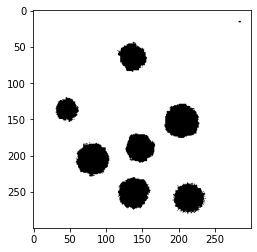

In [120]:
for i in range(img_height):
  for j in range(img_height):
    if i<15 or i>img_height-15 or j<15 or j>img_height-15:
      img4[i,j]=1
    if img4[i,j]<0.5:
      img4[i,j]=0
    if img4[i,j]>0.5:
      img4[i,j]=1
plt.imshow(img4,cmap='gray')

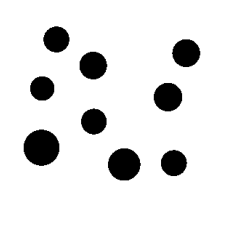

In [217]:
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
plt.show()
fig.savefig('img_3_0_{}.png'.format(numOfDisks),bbox_inches='tight')

In [162]:
os.listdir()

['confF.ipynb',
 'img0_1.png',
 'img0_10.png',
 'img0_2.png',
 'img0_3.png',
 'img0_4.png',
 'img0_5.png',
 'img0_6.png',
 'img0_7.png',
 'img0_8.png',
 'img0_9.png',
 'img1_1.png',
 'img1_10.png',
 'img1_2.png',
 'img1_3.png',
 'img1_4.png',
 'img1_5.png',
 'img1_6.png',
 'img1_7.png',
 'img1_8.png',
 'img1_9.png',
 'img2_1.png',
 'img2_10.png',
 'img2_2.png',
 'img2_3.png',
 'img2_4.png',
 'img2_5.png',
 'img2_6.png',
 'img2_7.png',
 'img2_8.png',
 'img2_9.png',
 'img3_1.png',
 'img3_10.png',
 'img3_2.png',
 'img3_3.png',
 'img3_4.png',
 'img3_5.png',
 'img3_6.png',
 'img3_7.png',
 'img3_8.png',
 'img3_9.png',
 'img_1_1.png',
 'img_1_10.png',
 'img_1_2.png',
 'img_1_3.png',
 'img_1_4.png',
 'img_1_5.png',
 'img_1_6.png',
 'img_1_7.png',
 'img_1_8.png',
 'img_1_9.png',
 'img_2_1.png',
 'img_2_10.png',
 'img_2_2.png',
 'img_2_3.png',
 'img_2_4.png',
 'img_2_5.png',
 'img_2_6.png',
 'img_2_7.png',
 'img_2_8.png',
 'img_2_9.png',
 'img_3_1.png',
 'img_3_10.png',
 'img_3_2.png',
 'img_3_3

In [8]:
lfiles=os.listdir()
x_train=[]
x_train1=[]
y_train=[]
y_train1=[]
x_test=[]
y_test=[]

for i in range(len(lfiles)):

    if lfiles[i][0:4]=='img0':
        x_train.append(cv2.resize(cv2.imread('C:/Users/Oona/Documents/Tpc/func/data/{}'.format(lfiles[i])),(128,128)))
        num=int(lfiles[i][-5])
        if num==0:
            num=10
        y_train.append(num)
        
    if lfiles[i][0:4]=='img0' or lfiles[i][0:4]=='img1' or lfiles[i][0:4]=='img2' or lfiles[i][0:4]=='img3':
        x_train1.append(cv2.resize(cv2.imread('C:/Users/Oona/Documents/Tpc/func/data/{}'.format(lfiles[i])),(128,128)))
        num=int(lfiles[i][-5])
        if num==0:
            num=10
        y_train1.append(num)

    if lfiles[i][0:4]=='img_':
        if lfiles[i][4]!='f':
            x_test.append(cv2.resize(cv2.imread('C:/Users/Oona/Documents/Tpc/func/data/{}'.format(lfiles[i])),(128,128)))
            num=int(lfiles[i][-5])
            if num==0:
                num=10
            y_test.append(num)

x_train=np.array(x_train)[:,:,:,0]
x_train1=np.array(x_train1)[:,:,:,0]
y_train=np.array(y_train)
y_train1=np.array(y_train1)
x_test=np.array(x_test)[:,:,:,0]
y_test=np.array(y_test)

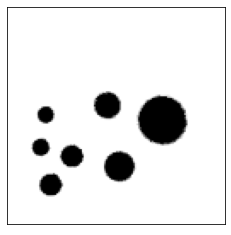

In [55]:
plt.imshow(x_train1[37],cmap='gray')
fig=plt.gcf()
plt.xticks([],labels='')
plt.yticks([],labels='')
plt.tick_params(left = False,top=False)
plt.show()
fig.savefig('img_f_7_3.png',bbox_inches='tight')

Epoch 1/130
1/1 [==============================] - 2s 2s/step - loss: 124.6218 - mean_squared_error: 124.6218 - val_loss: 48.5661 - val_mean_squared_error: 48.5661
Epoch 2/130
1/1 [==============================] - 0s 390ms/step - loss: 20.4460 - mean_squared_error: 20.4460 - val_loss: 4.4425 - val_mean_squared_error: 4.4425
Epoch 3/130
1/1 [==============================] - 0s 325ms/step - loss: 32.3068 - mean_squared_error: 32.3068 - val_loss: 23.6575 - val_mean_squared_error: 23.6575
Epoch 4/130
1/1 [==============================] - 0s 338ms/step - loss: 8.8612 - mean_squared_error: 8.8612 - val_loss: 15.0181 - val_mean_squared_error: 15.0181
Epoch 5/130
1/1 [==============================] - 0s 332ms/step - loss: 6.7641 - mean_squared_error: 6.7641 - val_loss: 3.5092 - val_mean_squared_error: 3.5092
Epoch 6/130
1/1 [==============================] - 0s 326ms/step - loss: 8.1162 - mean_squared_error: 8.1162 - val_loss: 8.4538 - val_mean_squared_error: 8.4538
Epoch 7/130
1/1 [======

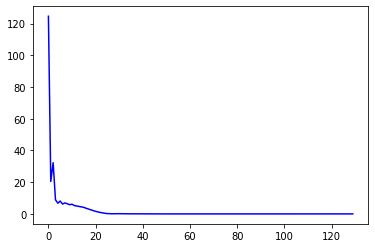

In [67]:
def Unet():
    
    model = keras.Sequential([layers.Conv2D(16, 3, activation='relu', input_shape=(128,128,1)),
                        layers.Conv2D(16, 3, activation='relu'),
                        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                        layers.Conv2D(32, 3, activation='relu'),
                        layers.Conv2D(32, 3, activation='relu'),
                        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                        layers.Conv2D(64, 3, activation='relu'),
                        layers.Conv2D(64, 3, activation='relu'),
                        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                        layers.Conv2D(128, 3, activation='relu'),
                        layers.Conv2D(128, 3, activation='relu'),
                        layers.MaxPooling2D(strides=(2, 2)),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(64, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1, activation='linear')
    ]
    )

    return model

model=Unet()
numEpochs=130
model.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError()])
history=model.fit(x=x_train,y=y_train,epochs=numEpochs,validation_split=0.3,shuffle=True)
trainPreds=model.predict(x_train)
predictions=model.predict(x_test)
plt.plot(range(numEpochs),history.history['loss'],color='blue')

Epoch 1/130
1/1 [==============================] - 2s 2s/step - loss: 19.4293 - mean_squared_error: 19.4293 - val_loss: 1284.3342 - val_mean_squared_error: 1284.3342
Epoch 2/130
1/1 [==============================] - 1s 931ms/step - loss: 1319.1326 - mean_squared_error: 1319.1326 - val_loss: 8.6973 - val_mean_squared_error: 8.6973
Epoch 3/130
1/1 [==============================] - 1s 949ms/step - loss: 7.2927 - mean_squared_error: 7.2927 - val_loss: 35.2495 - val_mean_squared_error: 35.2495
Epoch 4/130
1/1 [==============================] - 1s 935ms/step - loss: 29.2242 - mean_squared_error: 29.2242 - val_loss: 30.4578 - val_mean_squared_error: 30.4578
Epoch 5/130
1/1 [==============================] - 1s 912ms/step - loss: 24.5494 - mean_squared_error: 24.5494 - val_loss: 21.5733 - val_mean_squared_error: 21.5733
Epoch 6/130
1/1 [==============================] - 1s 907ms/step - loss: 17.1432 - mean_squared_error: 17.1432 - val_loss: 11.7540 - val_mean_squared_error: 11.7540
Epoch 7/1

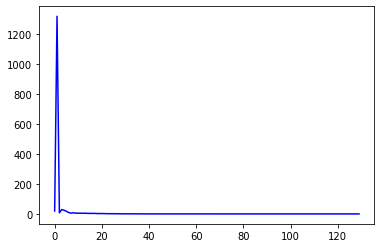

In [68]:
model=Unet()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError()])
history=model.fit(x=x_train1,y=y_train1,epochs=numEpochs,validation_split=0.3,shuffle=True)
trainPreds1=model.predict(x_train1)
predictions1=model.predict(x_test)
plt.plot(range(numEpochs),history.history['loss'],color='blue')

In [2]:
trainPreds=np.array([[1.0127414464950562], [10.136754035949707], [2.026564598083496], [3.045036554336548], [4.060452461242676], [5.078697681427002], [6.088337421417236], [7.876765727996826], [9.136340141296387], [9.461774826049805]])
trainPreds1=np.array([[0.9982733130455017], [9.994534492492676], [1.9980473518371582], [2.9988303184509277], [3.996370315551758], [4.996218681335449], [5.998117446899414], [6.997772216796875], [7.996722221374512], [8.997308731079102], [0.9985554814338684], [9.99549674987793], [1.9976294040679932], [2.9981913566589355], [3.9990243911743164], [4.996013164520264], [5.998572826385498], [6.995931148529053], [7.996313571929932], [8.995978355407715], [1.0017881393432617], [9.994335174560547], [1.998859167098999], [2.997699499130249], [3.9983468055725098], [4.998406410217285], [5.998126029968262], [6.998342037200928], [7.7433857917785645], [8.752256393432617], [1.3135771751403809], [7.451001167297363], [1.31473970413208], [5.058984756469727], [5.68829345703125], [6.2993364334106445], [4.190328598022461], [7.701077461242676], [6.271893501281738], [7.656055927276611]])
predictions=np.array([[4.4771223068237305], [9.638909339904785], [2.366671323776245], [5.482461929321289], [5.447105884552002], [6.3546857833862305], [7.965268135070801], [7.618391990661621], [10.196044921875], [7.139070510864258], [3.2263948917388916], [8.393275260925293], [1.583530068397522], [4.9950361251831055], [6.440106391906738], [5.496952533721924], [6.91128396987915], [7.049652576446533], [8.552835464477539], [8.9368314743042], [3.7817585468292236], [8.559453964233398], [2.4629292488098145], [5.5087971687316895], [6.949485778808594], [7.590262413024902], [6.824640274047852], [7.32537841796875], [8.451997756958008], [8.156423568725586], [3.626328706741333], [8.595996856689453], [2.5129125118255615], [4.6708292961120605], [4.142366409301758], [5.55275821685791], [8.093635559082031], [5.999496936798096], [8.768651962280273], [8.567554473876953], [4.538013458251953], [9.120704650878906], [3.014451503753662], [3.582850456237793], [5.721360683441162], [4.579110145568848], [7.9677510261535645], [8.119038581848145], [6.216642379760742], [7.411007881164551], [2.0267257690429688], [10.34246826171875], [4.201624870300293], [3.5739948749542236], [6.485206604003906], [6.4551920890808105], [6.328550815582275], [6.473507404327393], [8.6545991897583], [9.571622848510742], [3.2670626640319824], [9.8867769241333], [2.5289852619171143], [1.9353665113449097], [6.911471366882324], [6.1327409744262695], [6.369868755340576], [7.767100811004639], [8.912514686584473], [7.356240272521973], [3.7538886070251465], [8.712368965148926], [3.3697245121002197], [4.835682392120361], [7.026007652282715], [6.377383708953857], [6.927550315856934], [8.650805473327637], [8.953421592712402], [7.6645426750183105], [0.9853900074958801], [8.595913887023926], [1.7263343334197998], [6.099010467529297], [4.766720771789551], [7.500998497009277], [6.6497321128845215], [7.559785842895508], [7.592037677764893], [9.650067329406738], [1.832857608795166], [8.409366607666016], [2.2137153148651123], [3.5817010402679443], [4.311702728271484], [7.225521087646484], [8.791528701782227], [5.770459175109863], [8.297216415405273], [8.533178329467773], [4.585790157318115], [8.729730606079102], [5.159539222717285], [5.131884574890137], [4.105041980743408], [6.671023845672607], [6.441397666931152], [7.521239280700684], [7.990715503692627], [8.844552040100098], [0.9524654746055603], [9.271483421325684], [2.619720935821533], [2.8181426525115967], [3.435281753540039], [7.180176734924316], [5.2145280838012695], [7.899141311645508], [8.767106056213379], [8.110468864440918], [2.0568106174468994], [9.404117584228516], [2.004786968231201], [3.5813732147216797], [5.598333835601807], [5.631400108337402], [8.433241844177246], [7.890430450439453], [7.646969318389893], [8.711271286010742], [1.204939842224121], [9.165793418884277], [2.036200523376465], [4.6676836013793945], [5.557065010070801], [7.496885776519775], [5.742334365844727], [8.142494201660156], [8.599013328552246], [8.702507972717285], [3.2961556911468506], [7.480099201202393], [4.37770414352417], [5.246217250823975], [7.483755111694336], [7.643878936767578], [6.679998397827148], [6.683599472045898], [7.2383012771606445], [10.066280364990234], [3.2079811096191406], [9.869416236877441], [3.3412795066833496], [6.822641372680664], [3.6816959381103516], [3.848053216934204], [8.072157859802246], [5.622007369995117], [8.732878684997559], [9.427389144897461]])
predictions1=np.array([[3.316093921661377], [9.171154022216797], [3.891798973083496], [6.599562644958496], [6.191643238067627], [6.831965446472168], [8.054607391357422], [7.256855487823486], [9.472884178161621], [8.174049377441406], [3.185619592666626], [8.680307388305664], [1.84100341796875], [3.1362524032592773], [5.418856143951416], [5.395667552947998], [7.191242694854736], [7.289268970489502], [9.42269229888916], [9.308582305908203], [2.615229606628418], [9.287342071533203], [1.6529541015625], [5.602015495300293], [5.242307662963867], [5.578988552093506], [7.683691024780273], [6.830604553222656], [9.376022338867188], [8.555994033813477], [2.300971508026123], [9.576055526733398], [2.8307125568389893], [3.4032583236694336], [4.237288475036621], [5.428391456604004], [6.591335773468018], [7.339499473571777], [8.082635879516602], [9.067525863647461], [3.174738645553589], [8.487968444824219], [5.082179069519043], [3.1431431770324707], [4.422280311584473], [5.501887321472168], [7.6160478591918945], [7.257879734039307], [6.729590892791748], [8.24494743347168], [1.445656657218933], [9.965447425842285], [4.1533732414245605], [3.464376211166382], [4.738985538482666], [6.994725227355957], [6.603861331939697], [7.3546552658081055], [9.109450340270996], [9.840278625488281], [2.0842437744140625], [8.99034595489502], [1.3949449062347412], [2.7562978267669678], [6.3215718269348145], [5.955239295959473], [6.2992658615112305], [8.135756492614746], [9.115057945251465], [7.898224353790283], [1.8325493335723877], [9.279878616333008], [1.780914068222046], [6.005614280700684], [6.507494926452637], [5.944272041320801], [7.721304416656494], [8.446025848388672], [8.795403480529785], [8.489470481872559], [1.0407686233520508], [8.295336723327637], [2.625713348388672], [4.815287113189697], [3.752936840057373], [6.316993713378906], [7.071279525756836], [7.895195960998535], [8.098861694335938], [8.205734252929688], [1.1258571147918701], [9.34673023223877], [4.219010353088379], [4.088553428649902], [5.6164021492004395], [7.220080375671387], [7.516451835632324], [6.229600429534912], [8.50709342956543], [8.463285446166992], [3.721836566925049], [9.81179141998291], [4.4482526779174805], [5.687618255615234], [4.401947498321533], [5.638334274291992], [7.395411491394043], [8.28422737121582], [9.311017990112305], [8.741544723510742], [1.2843598127365112], [9.097321510314941], [3.0582528114318848], [3.5880179405212402], [4.760104656219482], [7.109034061431885], [6.413276195526123], [7.901362895965576], [8.092206001281738], [8.227804183959961], [1.2438942193984985], [9.905495643615723], [2.143103837966919], [4.620383262634277], [5.315472602844238], [5.658945083618164], [7.1719536781311035], [8.668255805969238], [9.658711433410645], [9.38206958770752], [1.3091286420822144], [9.139426231384277], [2.7990903854370117], [3.3648407459259033], [6.505838394165039], [6.07994270324707], [7.0886454582214355], [6.873944282531738], [8.60366153717041], [7.425411224365234], [3.4491162300109863], [8.705061912536621], [3.5676231384277344], [5.593603610992432], [7.041362762451172], [6.8649492263793945], [7.668285369873047], [5.792200088500977], [7.691423416137695], [9.641572952270508], [3.43558406829834], [9.801902770996094], [1.6148097515106201], [4.634629726409912], [4.4135894775390625], [4.566171646118164], [7.52923583984375], [5.632936954498291], [7.001075744628906], [9.701035499572754]])

In [3]:
np.savetxt('trainPreds.txt',trainPreds)
np.savetxt('trainPreds1.txt',trainPreds1)
np.savetxt('predictions.txt',predictions)
np.savetxt('predictions1.txt',predictions1)

In [2]:
trainPreds=np.loadtxt('trainPreds.txt')
trainPreds1=np.loadtxt('trainPreds1.txt')
predictions=np.loadtxt('predictions.txt')
predictions1=np.loadtxt('predictions1.txt')

In [5]:
t=[]
for i in range(10):
    t.append((trainPreds[i]-y_train[i])**2)
print(np.mean(t))
t1=[]
for i in range(40):
    t1.append((trainPreds1[i]-y_train1[i])**2)
print(np.mean(t1))
u=[]
for i in range(160):
    u.append((predictions[i]-y_test[i])**2)
print(np.mean(u))  
u1=[]
for i in range(160):
    u1.append((predictions1[i]-y_test[i])**2)
print(np.mean(u1))
print((np.mean(u)-np.mean(u1))/(np.mean(u)))

0.23124723535447203
0.613244077781547
2.3808488993765105
1.7427902897110894
0.2679962637832724


In [9]:
print(ttest_ind(u,u1))

NameError: name 'u' is not defined

In [21]:
np.corrcoef(y_test,predictions)

array([[1.        , 0.88445803],
       [0.88445803, 1.        ]])

In [12]:
b,a=np.polyfit(y_test,predictions1,deg=1)
print(a)
print(b)

1.845625679691632
0.7927584674322243


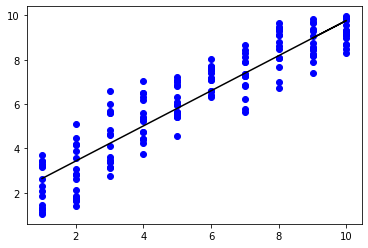

In [20]:
plt.scatter(y_test,predictions1,color='blue')
plt.plot(y_test,b*y_test+a,color='black')
fig=plt.gcf()
plt.show()
fig.savefig('preds1.png',bbox_inches='tight')